In [1]:
#本コードは下記サイトのほぼ流用です。一切の権利は主張しませんし、
#ご自身でどこかで使用する場合、オリジナルコード作成者が定義する権利範囲に従って下さい。
#http://qiita.com/ikki8412/items/95bc81a744dc377d9119
#http://enakai00.hatenablog.com/entry/2016/02/29/090112


In [4]:
import sys,os
import cv2
import numpy as np
import math
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from scipy import ndimage
from scipy.misc import imread, imsave, imresize

import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt


# mnistデータの読み込み
#下記はインターネット上からmnist（手書き数字データベース）をダウンロードし、
#バイナリ形式のファイルから画像を変換し、数値行列としてmnist変数に代入しています。
#なぜ画像ファイルそのものじゃなくてバイナリ形式を扱うのか？という理由については
#今回お話しませんので、各自調べてみて下さい。
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
print (mnist.test)
print (mnist.train)

#mnistはデータベース型変数で、testとtrainにそれぞれ画像データが入っています。
#実際の手書き数字のデータベースを取り込んでいます。

In [ ]:
#画像と紐付けられたラベルを表示してみましょう。
#print (mnist.test.images[0])
plt.imshow(mnist.test.images[0].reshape(28,28),cmap=plt.cm.gray)
print ("この画像データに紐付けられた正解ラベルは",mnist.test.labels[0],"です") 
#10個の配列のうち、７番目だけが１です。このような標記をone-hot-encodingといいます。

In [ ]:
#白背景に黒字のはずなのですが、画像解析では白を処理するのが基本なので逆転させてあります。
#一応カラーマップを逆転させたバージョンも表示させます。
plt.imshow(mnist.test.images[1].reshape(28,28),cmap=plt.cm.gray_r)

In [ ]:
#ここよりディープラーニングのコードです。

In [2]:
NUM_CLASSES = 10    # モデルのクラス数
def inference(images_placeholder, keep_prob):
    ####################################################################
    #  予測モデルを作成する関数
    #引数: 
    #  images_placeholder: 画像のplaceholder
    #  keep_prob: dropout率のplaceholder
    #返り値:
    #  y_conv: 各クラスの確率(のようなもの)
    ####################################################################

    # 重みを標準偏差0.1の正規分布で初期化
    def weight_variable(shape):
      initial = tf.truncated_normal(shape, stddev=0.1)
      return tf.Variable(initial)

    # バイアスを標準偏差0.1の正規分布で初期化
    def bias_variable(shape):
      initial = tf.constant(0.1, shape=shape)
      return tf.Variable(initial)

    # 畳み込み層の作成
    def conv2d(x, W):
      return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    # プーリング層の作成
    def max_pool_2x2(x):
      return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

    # 入力を28x28x1に変形
    x_images = tf.reshape(images_placeholder, [-1, 28, 28, 1])

    # 畳み込み層1の作成
    with tf.name_scope('conv1') as scope:
        W_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(conv2d(x_images, W_conv1) + b_conv1)

    # プーリング層1の作成
    with tf.name_scope('pool1') as scope:
        h_pool1 = max_pool_2x2(h_conv1)

    # 畳み込み層2の作成
    with tf.name_scope('conv2') as scope:
        W_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    # プーリング層2の作成
    with tf.name_scope('pool2') as scope:
        h_pool2 = max_pool_2x2(h_conv2)

    # 全結合層1の作成
    with tf.name_scope('fc1') as scope:
        W_fc1 = weight_variable([7*7*64, 1024])
        b_fc1 = bias_variable([1024])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        # dropoutの設定
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # 全結合層2の作成
    with tf.name_scope('fc2') as scope:
        W_fc2 = weight_variable([1024, NUM_CLASSES])
        b_fc2 = bias_variable([NUM_CLASSES])

    # ソフトマックス関数による正規化
    with tf.name_scope('softmax') as scope:
        y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

    # 各ラベルの確率のようなものを返す
    return y_conv


def loss(logits, labels):
    ####################################################################
    #  lossを計算する関数
    #引数:
    #  logits: ロジットのtensor, float - [batch_size, NUM_CLASSES]
    #  labels: ラベルのtensor, int32 - [batch_size, NUM_CLASSES]
    #返り値:
    #  cross_entropy: 交差エントロピーのtensor, float
    ####################################################################

    # 交差エントロピーの計算
    cross_entropy = -tf.reduce_sum(labels*tf.log(logits))
    # TensorBoardで表示するよう指定
    tf.scalar_summary("cross_entropy", cross_entropy)
    return cross_entropy


def training(loss, learning_rate):
    ####################################################################
    #  訓練のopを定義する関数
    #引数:
    #  loss: 損失のtensor, loss()の結果
    #  learning_rate: 学習係数
    #返り値:
    #  train_step: 訓練のop
    ####################################################################

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return train_step
def accuracy(logits, labels):
    ####################################################################
    #  正解率(accuracy)を計算する関数
    #引数: 
    #  logits: inference()の結果
    #  labels: ラベルのtensor, int32 - [batch_size, NUM_CLASSES]
    #返り値:
    #  accuracy: 正解率(float)
    ####################################################################

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    tf.scalar_summary("accuracy", accuracy)
    return accuracy

In [ ]:
#訓練ステップ
with tf.Graph().as_default():
    x_image = tf.placeholder("float", shape=[None,784])       # 入力
    y_label = tf.placeholder("float", shape=[None,10])       # 誤差関数用変数 真のclass Distribution
    #W = tf.Variable(tf.zeros([784,10]))     # 重み
    #b = tf.Variable(tf.zeros([10]))         # バイアス
    #y_label = tf.nn.softmax(tf.matmul(x_image,W)+b)     # y=softmax(Wx+b)微分も勝手に行ってくれる
    keep_prob = tf.placeholder("float")
    #init_op = tf.initialize_all_variables()    # 変数の初期化(変数使用の際必ず必要)
    logits = inference(x_image,keep_prob)   # inference()を呼び出してモデルを作成
    loss_value = loss(logits,y_label)       # loss()を呼び出して損失を計算
    train_op = training(loss_value,1e-4)    # training()を呼び出して訓練（1e-4は学習率）
    accur = accuracy(logits,y_label)     # accuracy()を呼び出して精度を計算
    init_op = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init_op)
    # TensorBoardで表示する値の設定
    summary_op = tf.merge_all_summaries()
    saver = tf.train.Saver(max_to_keep = 11)
    summary_writer = tf.train.SummaryWriter('tmp/', sess.graph)

    # 訓練の実行
    for step in range(101): #rangeの分だけ学習を繰り返します。 
        #1001-5001ぐらいで十分ですが、マシンパワーに依存しますのでお試しで101ぐらい回してみて下さい。
        batch = mnist.train.next_batch(50)
        if step % 50 == 0:
            train_accur = sess.run(accur,feed_dict={x_image: batch[0], y_label: batch[1], keep_prob:1.0})
            print ("step %d, training accuracy %g" % (step,train_accur))
        sess.run(train_op,feed_dict={x_image:batch[0],y_label:batch[1],keep_prob:0.5})# 0.5に抑えている?
        # 100 step終わるたびにTensorBoardに表示する値を追加する
        summary_str = sess.run(summary_op, feed_dict={
                x_image: batch[0],
                y_label: batch[1],
                keep_prob: 1.0})
        summary_writer.add_summary(summary_str, step)
        if step % 100 == 0:
            checkpoint_path = os.path.join("tmp/", 'model.ckpt')
            saver.save(sess, checkpoint_path, global_step=step)
    # 結果表示
    print ("test accuracy %g"%sess.run(accur, feed_dict={
                x_image:mnist.test.images,
                y_label:mnist.test.labels,
                keep_prob:1.0}))
    print ("終わりました。")

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]
入力された画像は 7 と判定されました。
予測値は 100.0 ％です


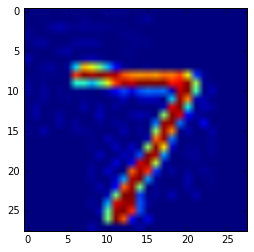

In [7]:
try:
    sess.close()
except Exception as e:
    print ("session assured closed")

#画像を評価してみよう。
tf.reset_default_graph()

#image/mnistディレクトリには0.jpgから49.jpgのサンプルファイルが入っています。
image_path = "image/mnist/0.jpg"
image_jpg = imread(image_path)
image = tf.convert_to_tensor(image_jpg,dtype=tf.float32)
logit = inference(image,1.0)

sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.initialize_all_variables())

#構築したモデルを読み込みます。
saver.restore(sess,"tmp_sample/model.ckpt-1000")


result=logit.eval()
print (result)
result2=np.argmax(result) #何番目の配列が最大値か返す処理です。#番目＝数字
#%も表示しましょう。

result = [n for n in result[0]] #型変換
percentage = result[result2]*100 #配列の該当する番目の数字を取り出し、100をかけます。

print ("入力された画像は",result2,"と判定されました。")
print ("予測値は",percentage,"％です")

plt.imshow(image_jpg)